In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [2]:
# ====================== 1. Load & Preprocess ======================
path = ".//weatherHistory.csv"  # غير المسار لو لازم
df = pd.read_csv(path)
df["Formatted Date"] = pd.to_datetime(df["Formatted Date"], utc=True)
df = df.sort_values("Formatted Date").reset_index(drop=True)


In [3]:
# Temperature bins (0=Cold, 1=Mild, 2=Hot)
def temp_to_obs(t):
    if t < 10:
        return 0
    elif t < 20:
        return 1
    else:
        return 2


df["Obs"] = df["Temperature (C)"].apply(temp_to_obs)
O = df["Obs"].values.astype(int)

print("Observation distribution:")
print(pd.Series(O).value_counts().sort_index())


Observation distribution:
0    42436
1    33340
2    20677
Name: count, dtype: int64


In [4]:
# Split
train_ratio = 0.7
split = int(len(O) * train_ratio)
O_train = O[:split]
O_test = O[split:]

print(f"Train: {len(O_train)}, Test: {len(O_test)}")


Train: 67517, Test: 28936


In [5]:
# ====================== 2. Parameters ======================
N = 3  # Hidden states
M = 3  # Observations


In [6]:
# ====================== 3. Initialization (Dirichlet - أفضل) ======================
rng = np.random.default_rng(seed=42)
pi = rng.dirichlet([1.0] * N)
A = np.vstack([rng.dirichlet([1.0] * N) for _ in range(N)])
B = np.vstack([rng.dirichlet([1.0] * M) for _ in range(N)])

print("Initial pi:", pi.round(3))
print("Initial A:\n", A.round(3))
print("Initial B:\n", B.round(3))


Initial pi: [0.337 0.328 0.335]
Initial A:
 [[0.154 0.048 0.799]
 [0.306 0.677 0.017]
 [0.474 0.032 0.494]]
Initial B:
 [[0.517 0.115 0.368]
 [0.274 0.163 0.562]
 [0.352 0.161 0.487]]


In [7]:
# ====================== 4. Scaled Forward ======================
def forward_scaled(O, pi, A, B):
    T = len(O)
    alpha = np.zeros((T, N))
    c = np.zeros(T)  # scaling coefficients

    alpha[0] = pi * B[:, O[0]]
    c[0] = alpha[0].sum()
    if c[0] == 0: c[0] = 1e-12
    alpha[0] /= c[0]

    for t in range(1, T):
        alpha[t] = (alpha[t - 1] @ A) * B[:, O[t]]
        c[t] = alpha[t].sum()
        if c[t] == 0: c[t] = 1e-12
        alpha[t] /= c[t]

    log_likelihood = np.sum(np.log(c))
    return alpha, c, log_likelihood


In [8]:
# ====================== 5. Scaled Backward ======================
def backward_scaled(O, A, B, c):
    T = len(O)
    beta = np.zeros((T, N))
    beta[T - 1] = 1.0

    for t in range(T - 2, -1, -1):
        beta[t] = A @ (B[:, O[t + 1]] * beta[t + 1])
        beta[t] /= c[t + 1]  # مهم جداً

    return beta


In [9]:
# ====================== 6. Baum-Welch (الصحيح 100%) ======================
def baum_welch(O, pi_init, A_init, B_init, max_iter=50, tol=1e-5):
    pi = pi_init.copy()
    A = A_init.copy()
    B = B_init.copy()

    loglik_history = []

    for it in range(max_iter):
        # E-step
        alpha, c, loglik = forward_scaled(O, pi, A, B)
        beta = backward_scaled(O, A, B, c)

        loglik_history.append(loglik)
        print(f"Iteration {it + 1:2d} | Log-Likelihood: {loglik:.2f}")

        # gamma (P(state_t | O))
        gamma = alpha * beta
        gamma /= gamma.sum(axis=1, keepdims=True)

        # xi (P(state_t=i, state_{t+1}=j | O))
        xi = np.zeros((len(O) - 1, N, N))
        for t in range(len(O) - 1):
            joint = (alpha[t][:, None] * A * B[:, O[t + 1]][None, :] * beta[t + 1][None, :])
            xi[t] = joint / joint.sum()

        # M-step
        pi_new = gamma[0]

        A_new = xi.sum(axis=0)
        A_new /= A_new.sum(axis=1, keepdims=True)

        B_new = np.zeros((N, M))
        for k in range(M):
            mask = (O == k)
            B_new[:, k] = gamma[mask].sum(axis=0)
        B_new /= B_new.sum(axis=1, keepdims=True)

        # Update
        pi, A, B = pi_new, A_new, B_new

        # Convergence check
        if it > 0 and abs(loglik_history[-1] - loglik_history[-2]) < tol:
            print(f"Converged after {it + 1} iterations!")
            break

    return pi, A, B, loglik_history


In [10]:
# ====================== 7. Run Training ======================
pi_old = pi.copy()
A_old = A.copy()
B_old = B.copy()

loglik_init = forward_scaled(O_train, pi_old, A_old, B_old)[2]
print(f"\nInitial Log-Likelihood: {loglik_init:.2f}")

print("\nStarting Baum-Welch training...\n" + "=" * 50)
pi_new, A_new, B_new, history = baum_welch(O_train, pi, A, B, max_iter=40)



Initial Log-Likelihood: -83120.29

Starting Baum-Welch training...
Iteration  1 | Log-Likelihood: -83120.29
Iteration  2 | Log-Likelihood: -63463.83
Iteration  3 | Log-Likelihood: -44026.75
Iteration  4 | Log-Likelihood: -36875.74
Iteration  5 | Log-Likelihood: -35153.18
Iteration  6 | Log-Likelihood: -34892.81
Iteration  7 | Log-Likelihood: -34859.15
Iteration  8 | Log-Likelihood: -34853.73
Iteration  9 | Log-Likelihood: -34852.28
Iteration 10 | Log-Likelihood: -34851.54
Iteration 11 | Log-Likelihood: -34850.97
Iteration 12 | Log-Likelihood: -34850.47
Iteration 13 | Log-Likelihood: -34850.01
Iteration 14 | Log-Likelihood: -34849.58
Iteration 15 | Log-Likelihood: -34849.18
Iteration 16 | Log-Likelihood: -34848.81
Iteration 17 | Log-Likelihood: -34848.47
Iteration 18 | Log-Likelihood: -34848.15
Iteration 19 | Log-Likelihood: -34847.85
Iteration 20 | Log-Likelihood: -34847.56
Iteration 21 | Log-Likelihood: -34847.30
Iteration 22 | Log-Likelihood: -34847.05
Iteration 23 | Log-Likelihood:


TRAINING COMPLETED!

Initial Emission Matrix (B):
         Cold (<10°C)  Mild (10-20°C)  Hot (>20°C)
State 1         0.517           0.115        0.368
State 2         0.274           0.163        0.562
State 3         0.352           0.161        0.487

Final Emission Matrix (B):
         Cold (<10°C)  Mild (10-20°C)  Hot (>20°C)
State 1         0.999           0.001        0.000
State 2         0.003           0.601        0.396
State 3         0.992           0.008        0.000

Initial Transition Matrix (A):
         State 1  State 2  State 3
State 1    0.154    0.048    0.799
State 2    0.306    0.677    0.017
State 3    0.474    0.032    0.494

Final Transition Matrix (A):
         State 1  State 2  State 3
State 1    0.165    0.027    0.808
State 2    0.021    0.978    0.001
State 3    0.479    0.029    0.492

Log-Likelihood Improvement: +48276.17


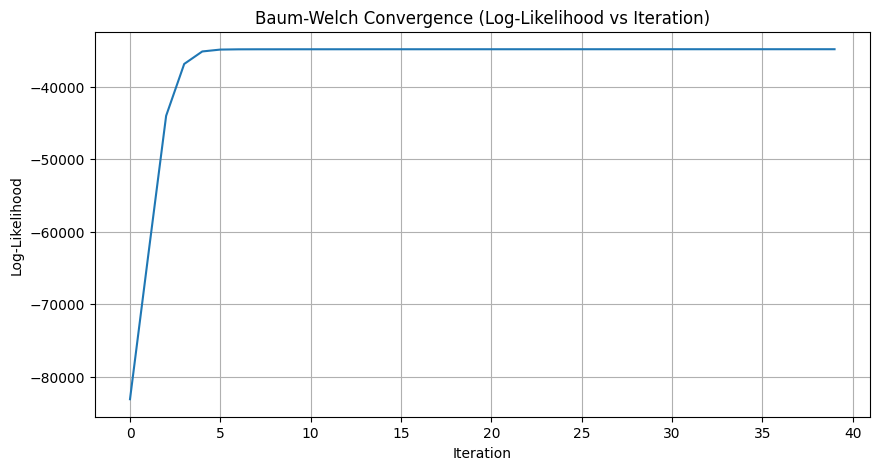


State Interpretation:
  • State 1 → Mostly Cold (<10°C) (prob = 0.999)
  • State 2 → Mostly Mild (10-20°C) (prob = 0.601)
  • State 3 → Mostly Cold (<10°C) (prob = 0.992)


In [11]:
# ====================== 8. Final Results & Analysis ======================
print("\n" + "=" * 60)
print("TRAINING COMPLETED!")
print("=" * 60)

# Before vs After
obs_names = ["Cold (<10°C)", "Mild (10-20°C)", "Hot (>20°C)"]
state_names = [f"State {i + 1}" for i in range(N)]

print("\nInitial Emission Matrix (B):")
print(pd.DataFrame(B_old, index=state_names, columns=obs_names).round(3))

print("\nFinal Emission Matrix (B):")
print(pd.DataFrame(B_new, index=state_names, columns=obs_names).round(3))

print("\nInitial Transition Matrix (A):")
print(pd.DataFrame(A_old, index=state_names, columns=state_names).round(3))

print("\nFinal Transition Matrix (A):")
print(pd.DataFrame(A_new, index=state_names, columns=state_names).round(3))

# Log-likelihood improvement
final_ll = history[-1]
print(f"\nLog-Likelihood Improvement: {final_ll - loglik_init:+.2f}")

# Plot convergence
plt.figure(figsize=(10, 5))
plt.plot(history)
plt.title("Baum-Welch Convergence (Log-Likelihood vs Iteration)")
plt.xlabel("Iteration")
plt.ylabel("Log-Likelihood")
plt.grid(True)
plt.show()

# State Interpretation
print("\nState Interpretation:")
for i in range(N):
    dominant_obs = obs_names[np.argmax(B_new[i])]
    prob = B_new[i].max()
    print(f"  • {state_names[i]} → Mostly {dominant_obs} (prob = {prob:.3f})")
